<a href="https://colab.research.google.com/github/Aditib2409/EE-541-Project/blob/main/chords_classification_Amin2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os
import torch 
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from scipy.signal import spectrogram, find_peaks
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Unzipping datasets and merging them

In [ ]:
!unzip "/content/drive/Shareddrives/EE541Project/archive.zip"   # 859 datapoints

Archive:  /content/drive/Shareddrives/EE541Project/archive.zip
  inflating: Audio_Files/Major/Major_0.wav  
  inflating: Audio_Files/Major/Major_1.wav  
  inflating: Audio_Files/Major/Major_10.wav  
  inflating: Audio_Files/Major/Major_100.wav  
  inflating: Audio_Files/Major/Major_101.wav  
  inflating: Audio_Files/Major/Major_102.wav  
  inflating: Audio_Files/Major/Major_103.wav  
  inflating: Audio_Files/Major/Major_104.wav  
  inflating: Audio_Files/Major/Major_105.wav  
  inflating: Audio_Files/Major/Major_106.wav  
  inflating: Audio_Files/Major/Major_107.wav  
  inflating: Audio_Files/Major/Major_108.wav  
  inflating: Audio_Files/Major/Major_109.wav  
  inflating: Audio_Files/Major/Major_11.wav  
  inflating: Audio_Files/Major/Major_110.wav  
  inflating: Audio_Files/Major/Major_111.wav  
  inflating: Audio_Files/Major/Major_112.wav  
  inflating: Audio_Files/Major/Major_113.wav  
  inflating: Audio_Files/Major/Major_114.wav  
  inflating: Audio_Files/Major/Major_115.wav  
  i

### Loading Dataset

In [ ]:
class loading_dataset:
    def __init__(self, path):
        self.path = path

    def harmonics(self, file_path, print=False):
        freq, X = wavfile.read(file_path)
        n = len(X)   
        X_fourier = fft(X)
        X_fourier_onesided = 2.0/n * np.abs(X_fourier[0:n // 2])
        frequencies = fftfreq(n, 1/freq)[:n//2]
        freqs_50_index = np.argmin(np.abs(frequencies - 50))
        
        ht = np.max(X_fourier_onesided)*5/100
        peaks_found, _ = find_peaks(X_fourier_onesided, distance=10, height=ht)
        peaks_found = peaks_found[peaks_found>freqs_50_index]
        harmonics_found = np.round(frequencies[peaks_found],2)

        if print:
            p = np.max(peaks_found) + 100
            plt.plot(frequencies[:p], X_fourier_onesided[:p])
            plt.plot(frequencies[peaks_found], X_fourier_onesided[peaks_found], 'o')
            plt.xlabel(f'Frequency in Hz')
            plt.ylabel(f'Harmonics')
            plt.show()
        
        return harmonics_found

    
    def create_dataframe(self):
        # to track the length of a harmonic
        length_harmonic = 0
        dataset = []

        for dir_name, _, file_name in os.walk(self.path):
            for filename in file_name:
                folder_name = os.path.basename(dir_name)
                full_filepath = os.path.join(dir_name, filename)
                harmonic_peaks = self.harmonics(full_filepath)
                min_harmonics = harmonic_peaks.min()
                max_harmonics = harmonic_peaks.max()
                num_peaks = len(harmonic_peaks)
                length_harmonic = max(num_peaks, length_harmonic)
                current_data = [folder_name, filename, min_harmonics, max_harmonics, num_peaks] 
                current_data.extend(harmonic_peaks)

                dataset.append(current_data)

        feature_cols = ["Chord_type", "File_name", "Minimum_harmonic", "Maximum_harmonic", "Num_harmonics"]
        for i in range(length_harmonic):
            feature_cols.append(f'Harmonic {i+1}')

        data_df = pd.DataFrame(dataset, columns=feature_cols)

        return data_df

In [ ]:
#path = "/content/drive/MyDrive/Audio_Files"
path = "/content/Audio_Files"
dataloader = loading_dataset(path)
data = dataloader.create_dataframe()
data_og = data

In [ ]:
def plot_kde(I, df):
    rows = len(I)
    fig, axes = plt.subplots(nrows=1, ncols=rows, figsize=(25, 3), sharex=True, sharey=True)
    axes = axes.ravel()
    for i in range(rows):
        if i <= len(I)-1:
            sns.kdeplot(ax=axes[i], data=df, x=I[i], hue="Chord_type", shade=True, palette="Set2")
    fig.suptitle(f'KDE plots of Selected Features')
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/kde_intervals.png')
    plt.show()

In [ ]:
def plot_kde_features(I, df):
    fig, axes = plt.subplots(nrows=9, ncols=3, figsize=(15, 35))
    axs = axes.ravel()
    for i in range(len(I)):
        if i <= len(I)-1:
            sns.kdeplot(ax=axs[i], data=df, x=I[i], hue="Chord_type", shade=True)
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/kde_features.png')
    plt.show()

### Creating intervals

In [ ]:
intervals = ["octave", "quinta", "quarta", "major inertia", "minor inertia"]
for i in range(len(intervals)):
    data[intervals[i]] = np.divide(data[f'Harmonic {i+2}'], data[f'Harmonic {i+1}'])

# adding more intervals
for i in range(len(intervals)):
    for j in range(i+1, len(intervals)):
        data[f'interval_{i+1}_{j+1}'] = np.divide(data[intervals[j]], data[intervals[i]])

## gives list of all harmonics that have NANs. we drop those harmonics
data.isnull().sum(axis = 0)

drop_harmonics = data.columns[13:43] ## NAN values
data = data.drop(drop_harmonics, axis=1)
data = data.drop("File_name", axis=1)
new_list = list(data.columns)
plot_kde_features(new_list[1:], data)

## Feature Selection

In [ ]:
data

,Chord_type,Minimum_harmonic,Maximum_harmonic,Num_harmonics,Harmonic 1,Harmonic 2,Harmonic 3,Harmonic 4,Harmonic 5,Harmonic 6,...,interval_1_2,interval_1_3,interval_1_4,interval_1_5,interval_2_3,interval_2_4,interval_2_5,interval_3_4,interval_3_5,interval_4_5
0,Minor,103.64,1250.91,18,103.64,176.36,185.45,190.00,207.73,247.27,...,0.617951,0.602080,0.642500,0.699519,0.974316,1.039726,1.131997,1.067134,1.161838,1.088746
1,Minor,98.67,2200.44,25,98.67,175.11,197.33,234.22,294.67,349.78,...,0.634975,0.668814,0.708902,0.668857,1.053292,1.116426,1.053360,1.059940,1.000065,0.943511
2,Minor,146.82,2449.09,28,146.82,208.64,247.27,293.64,349.55,416.82,...,0.833991,0.835663,0.837687,0.839125,1.002005,1.004431,1.006156,1.002421,1.004143,1.001717
3,Minor,155.45,2224.55,22,155.45,220.91,311.82,370.45,442.27,466.82,...,0.993262,0.835990,0.840104,0.742741,0.841661,0.845803,0.747779,1.004922,0.888457,0.884105
4,Minor,155.45,2224.55,26,155.45,234.09,262.27,311.36,370.45,468.18,...,0.744001,0.788355,0.790087,0.839250,1.059616,1.061943,1.128022,1.002196,1.064557,1.062225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
854,Major,174.67,1052.89,12,174.67,208.44,262.22,344.00,350.22,354.67,...,1.054198,1.099335,0.853139,0.848635,1.042816,0.809278,0.805005,0.776050,0.771953,0.994720
855,Major,83.04,919.14,18,83.04,130.87,146.96,165.22,208.26,247.83,...,0.712535,0.713363,0.799817,0.755084,1.001162,1.122494,1.059715,1.121191,1.058485,0.944071
856,Major,174.67,876.89,11,174.67,233.33,293.78,350.22,393.33,466.22,...,0.942539,0.892414,0.840744,0.887323,0.946819,0.891999,0.941417,0.942101,0.994295,1.055401
857,Major,131.11,919.11,16,131.11,174.67,233.33,261.78,293.78,350.22,...,1.002697,0.842138,0.842371,0.894821,0.839873,0.840105,0.892414,1.000276,1.062558,1.062265


In [ ]:
def get_selected_features(df):
    data_x = df.drop("Chord_type", axis=1)
    normalizer = StandardScaler()
    data_norm = normalizer.fit_transform(data_x)
    data_y = np.zeros(len(data_x), dtype='uint16')
    data_y[np.where(df["Chord_type"] == "Minor")] = 1

    pca = PCA()
    data_pca = pca.fit_transform(data_norm)

    explained_variance = pca.explained_variance_ratio_
    plt.plot(explained_variance, marker='o', color='black')
    plt.title('Variances in each component')
    plt.xlabel('num of features')
    plt.ylabel('variances')

    for i in range(len(explained_variance)):
        sum_variances = explained_variance[0:i].sum()
        if sum_variances > 0.98:
            num_components = i
            break
    
    y0 = explained_variance[num_components]
    plt.plot(num_components, y0, marker='s', color='red', label=f"num_components={num_components}")
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/pca_variances.png')
    plt.legend()

    plt.figure()
    plot = plt.scatter(data_pca[:,0], data_pca[:,1], c=data_y)
    plt.legend(handles=plot.legend_elements()[0], labels=['Major', 'Minor'])
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/2d_pca.png')
    plt.show()

    plt.figure()
    axs = plt.axes(projection='3d')
    plot = axs.scatter(data_pca[:,0], data_pca[:,1], c=data_y)
    plt.legend(handles=plot.legend_elements()[0], labels=['Major', 'Minor'])
    plt.savefig(f'/content/drive/Shareddrives/EE541Project/Figures/Data Preprocessing/3d_pca.png')
    plt.show()

    ## Recursive feature analysis
    model_tree = RandomForestClassifier(random_state=100, n_estimators=50)
    sel_rfe_tree = RFE(estimator=model_tree, n_features_to_select=num_components, step=1)
    X_train_rfe_tree = sel_rfe_tree.fit_transform(data_norm, data_y)
    sel_feature_indices = sel_rfe_tree.ranking_
    # print(sel_feature_indices)

    sel_columns = data_x.columns[np.where(sel_feature_indices == 1)]

    plot_kde(sel_columns, data)

    data_transformed_x = data_x[sel_columns]

    return data_transformed_x, data_y

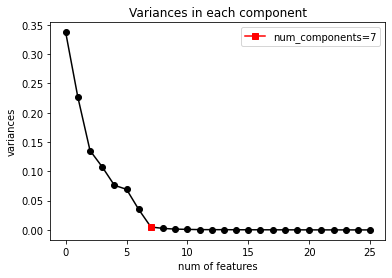

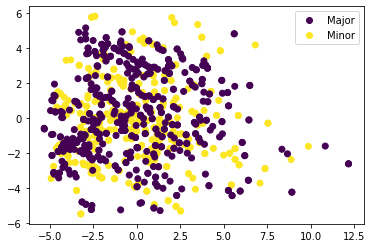

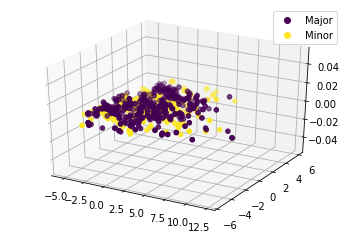

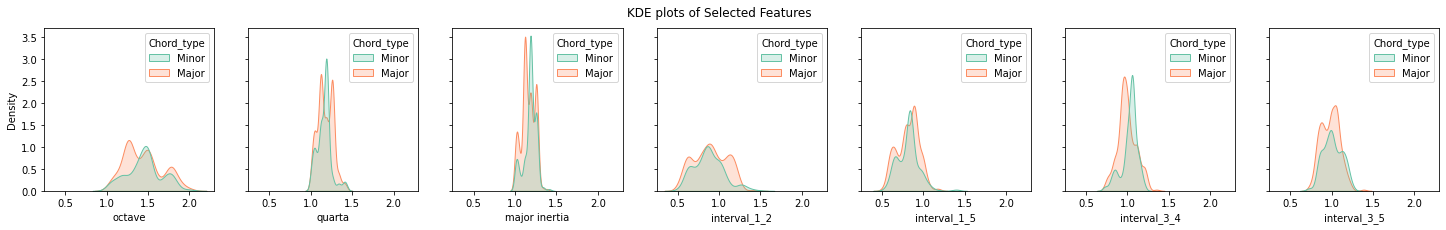

In [ ]:
data_x, data_y = get_selected_features(data)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(data_x, pd.Series(data_y, name="chord_type"), test_size=0.15, random_state=42)

In [ ]:
train_csv = pd.concat([train_x, train_y], axis=1)
test_csv = pd.concat([test_x, test_y], axis=1)

In [ ]:
train_csv

,octave,quarta,major inertia,interval_1_2,interval_1_5,interval_3_4,interval_3_5,chord_type
346,1.695652,1.055851,1.192276,0.661987,0.727682,1.129209,1.168627,1
5,1.193336,1.192388,1.236432,0.938052,0.853139,1.036937,0.853817,1
54,1.333333,1.188863,1.127068,0.840739,0.837592,0.948021,0.939375,1
424,1.591025,1.024930,1.256666,0.774259,0.748041,1.226100,1.161204,0
291,1.688474,1.186584,1.188955,0.702661,0.630039,1.001998,0.896527,1
...,...,...,...,...,...,...,...,...
71,1.414869,1.016769,1.185716,0.981261,0.844520,1.166161,1.175179,1
106,1.056996,1.261715,1.027470,1.337976,1.032087,0.814344,0.864626,1
270,1.054232,1.189703,1.414230,1.127579,0.962495,1.188725,0.852897,1
435,1.487494,1.129090,1.253670,0.802204,0.785966,1.110337,1.035454,0


In [ ]:
train_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Train", encoding='utf-8', index=False)
test_csv.to_csv("/content/drive/Shareddrives/EE541Project/Data/Test", encoding='utf-8', index=False)

# Model Implementation


In [ ]:
traindata = pd.read_table("/content/drive/Shareddrives/EE541Project/Data/Train",
                          sep=',')
testdata = pd.read_table("/content/drive/Shareddrives/EE541Project/Data/Test",
                          sep=',')
X_train = traindata.iloc[:, :-1]
Y_train = traindata.iloc[:, -1]
X_test = testdata.iloc[:, :-1]
Y_test = testdata.iloc[:, -1]

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score

# Functions
def calcAccuracy(labels, preds):
    return np.mean(labels == preds)

def plotConfMat(labels, preds):
    confmat = confusion_matrix(labels, preds)
    p = sns.heatmap(confmat, annot=True, fmt='g')
    p.set_xlabel("Prediction", fontsize = 20)
    p.set_ylabel("Reference", fontsize = 20)
    return p


# Random Forest
rf = RandomForestClassifier(n_estimators = 1000, random_state = 42)
rf.fit(X_train, Y_train)
rf_pred = rf.predict(X_test)

# Naive Bayes
nb = GaussianNB()
nb.fit(X_train, Y_train)
nb_pred = nb.predict(X_test)

# SVM:
svc_l = SVC(C=2, kernel='linear')     # Linear kernel
svc_p = SVC(C=2, kernel='poly') # polynomial kernel
svc_r = SVC(C=2, kernel='rbf')        # radial kernel

svc_l.fit(X_train, Y_train)
svc_l_pred = svc_l.predict(X_test)

svc_p.fit(X_train, Y_train)
svc_p_pred = svc_p.predict(X_test)

svc_r.fit(X_train, Y_train)
svc_r_pred = svc_r.predict(X_test)

In [ ]:
print("Naive Bayes:", calcAccuracy(Y_test, nb_pred))
print("SVM Linear:", calcAccuracy(Y_test, svc_l_pred))
print("SVM Polynomial:", calcAccuracy(Y_test, svc_p_pred))
print("SVM Radial:", calcAccuracy(Y_test, svc_r_pred))
print("Random Forest:", calcAccuracy(Y_test, rf_pred))

Naive Bayes: 0.7364341085271318
SVM Linear: 0.6124031007751938
SVM Polynomial: 0.689922480620155
SVM Radial: 0.6976744186046512
Random Forest: 0.9534883720930233


In [ ]:
print(rf_pred)

[0 0 1 1 0 0 0 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 0
 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 1 1
 1 0 0 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1
 1 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 1]


## Neural Network

In [ ]:
class ChordClassifier(nn.Module):
    
    def __init__(self, dropout_rate, dims):
        super(ChordClassifier, self).__init__()

        # use nn.Sequential module to wrap up all the layers
        self.net = nn.Sequential(
            nn.Linear(dims['input'], dims['hidden_1']),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dims['hidden_1'], dims['hidden_2']),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(dims['hidden_2'], dims['output']),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        output = self.net(x)
        return output


In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(X_train, Y_train,
                                                      test_size=0.15)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()[..., np.newaxis]
x_valid = x_valid.to_numpy()
y_valid = y_valid.to_numpy()[..., np.newaxis]
X_test = X_test.to_numpy()
Y_test = Y_test.to_numpy()[..., np.newaxis]

In [ ]:
# hyperparameters
dropout_rate = 0
learning_rate = 0.001 # low learning rate
lmb = 0.0001 # L2-regularization
epochs = 3000
batch_size = 1000
dims = {
    'input': 7,
    'hidden_1': 5,
    'hidden_2': 3,
    'output': 1
       }

# build a binary classification model
model = ChordClassifier(dropout_rate=dropout_rate, dims=dims)

# create optimizer and loss instances
opt = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lmb)
loss_func = nn.BCELoss()

# start training

train_losses = []
valid_losses = []
train_accs = []
valid_accs = []

for ep in range(epochs):
    model.train()
    x_train = torch.Tensor(x_train)
    y_train = torch.Tensor(y_train)
    y_hat = model(x_train)
    loss = loss_func(y_hat, y_train)
    opt.zero_grad()
    loss.backward()
    train_losses.append(loss.data.numpy())
    opt.step()

In [ ]:
print(train_losses)

[array(0.6901402, dtype=float32), array(0.6898696, dtype=float32), array(0.6896091, dtype=float32), array(0.6893549, dtype=float32), array(0.6891084, dtype=float32), array(0.6888603, dtype=float32), array(0.6886123, dtype=float32), array(0.68836224, dtype=float32), array(0.6881164, dtype=float32), array(0.6878785, dtype=float32), array(0.68765354, dtype=float32), array(0.68742627, dtype=float32), array(0.68720204, dtype=float32), array(0.6869816, dtype=float32), array(0.6867666, dtype=float32), array(0.68655723, dtype=float32), array(0.68635285, dtype=float32), array(0.68615395, dtype=float32), array(0.68596315, dtype=float32), array(0.68577987, dtype=float32), array(0.6856021, dtype=float32), array(0.6854475, dtype=float32), array(0.6853068, dtype=float32), array(0.6851477, dtype=float32), array(0.6849889, dtype=float32), array(0.6848585, dtype=float32), array(0.684751, dtype=float32), array(0.6846515, dtype=float32), array(0.6845443, dtype=float32), array(0.6844282, dtype=float32), a